The following section contains all the packages used in the 4th assignment

In [1]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
from random import shuffle
from math import ceil
from sklearn import preprocessing
from sklearn.decomposition import PCA
%matplotlib notebook
%matplotlib inline
%pylab inline
from sklearn.metrics import confusion_matrix, roc_curve, auc, precision_recall_curve,average_precision_score
from sklearn import metrics 
import numpy as np
import tensorflow as tf
tf.reset_default_graph()
tf.set_random_seed(1989)
from keras import optimizers
from keras.models import Sequential
from keras import backend as K
from keras.layers import Input,Merge, Dense, Activation,LSTM
from keras.layers import Bidirectional,Dropout,SimpleRNN, Embedding, Dense, LSTM
from keras.layers.core import Lambda, Reshape, Masking
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import GRU
from keras.models import Model
from keras.objectives import categorical_crossentropy
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from collections import Counter

Populating the interactive namespace from numpy and matplotlib


C:\Users\Dell\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['ceil', 'shuffle']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"
Using TensorFlow backend.


First step is to load the spam-ham enron emails

In [2]:

# Reads ham and spam files
ham=[]
path='C:/Users/Dell/Desktop/ASOE/2nd semester/Text analytics/exercise 4/ham/'
dirs = os.listdir( path )
for filename in dirs:
        file = open(path+filename, "r", encoding="utf-8")   
        ham.append([file.read(), 0])
        file.close()


spam=[]
path2='C:/Users/Dell/Desktop/ASOE/2nd semester/Text analytics/exercise 4/spam/'
dirs2 = os.listdir( path2 )
for filename2 in dirs2:
        try :
            with open(path2+filename2, "r", encoding="utf-8") as file2:
                spam.append([file2.read(), 1])
        except:
            pass

print('Number of ham is {}, while number of spam is {}'.format(len(ham),len(spam)))

Number of ham is 3672, while number of spam is 1485


After that, we split the data into training and test data and assign the labels 0 to ham and 1 to spam

In [3]:
# Concatenates and shuffles the dataset
dataset = ham + spam
np.random.seed(1)
shuffle(dataset)

train_set = dataset[:int(ceil(len(dataset)*0.8))]
test_set = dataset[int(ceil(len(dataset)*0.8)):]

#determine the absolute size of training and test data
N_train=len(train_set)
N_test=len(test_set)
print ('The dataset contains {} train samples and {} test samples'.format(N_train,N_test)) 

# Reads class labels
label_train = [item[1] for item in train_set]
label_test = [item[1] for item in test_set]

train_set = [item[0] for item in train_set[:]]
test_set = [item[0] for item in test_set[:]]

The dataset contains 4126 train samples and 1031 test samples


Preprocessing phase for the MLP model consists of conversion of data to tf-idf scores and then normalization of the data (unit l2 norm). After these two steps we select the such a combination of features using PCA, so that we retrieve 60 % of the variation of the initial data.


In [4]:
#conversion to TF-IDF scores
vectorizer = TfidfVectorizer(stop_words='english',min_df=5)
X_train_transformer = vectorizer.fit_transform(train_set)
X_train = X_train_transformer.toarray()

X_test_transformer = vectorizer.transform(test_set)
X_test = X_test_transformer.toarray()


#data normalization 
X_train_init,X_test_init=X_train[:],X_test[:]
X_train =preprocessing.normalize(X_train, norm='l2')
X_test = preprocessing.normalize(X_test, norm='l2')

# k may be either an integer greater than zero
# or a double between 0 and 1
def select_features_pca(train_X, test_X, k):
    selector = PCA(n_components=k)
    selector.fit(train_X)
    train_X = selector.transform(train_X)
    test_X = selector.transform(test_X)
    return train_X, test_X

# PCA
k = 0.6
train_x_sub, test_x_sub = select_features_pca(X_train, X_test, k)

print('previous train shape : ')
print(X_train_init.shape)
print('new train shape : ')
print(train_x_sub.shape)
print('previous test shape :')
print(X_test_init.shape)
print('new test shape :')
print(test_x_sub.shape)



previous train shape : 
(4126, 6965)
new train shape : 
(4126, 417)
previous test shape :
(1031, 6965)
new test shape :
(1031, 417)


The following chunks of code are functions that will be used during the evaluation and visualisation phase. The first function, 'benchmark', gets class prediction for a provided dataset and then calculates accuracy, precision, recall and f1-score.

In [11]:
def benchmark(model, X_train, y_train, X_test, y_test):
    
    #fit the NN model to the data
    model.fit(
    X_train,                      
    y_train,
    epochs=20,
    batch_size=64,
    verbose=0,
    validation_split=0.2
    )
    
    #get predictions, based on which all metrics will be calculated
    predict = model.predict_classes(np.array(X_test))
    f1_score = metrics.f1_score(y_test, predict, average='weighted')
    acc = metrics.accuracy_score(y_test, predict)
    precision = metrics.precision_score(y_test, predict)
    recall = metrics.recall_score(y_test, predict)
    result = {'f1_score' : f1_score, 'accuracy' : acc, 'train_size' : len(y_train),
              'test size' : len(y_test), 'recall': recall, 'precision': precision,
              'predictions': predict }
    
    return result

The following function splits the initial data into ten chunks and begins by one chunk and gradually increases the initial size by addition of an extra data chunk, so as to check the impact of data increase on accuracy, precision, recall and f1-score. This is done simultaneously for both training and test data. This function calls the benchmark function in order to calculate any metrics needed.

In [12]:
def get_results(model, X_train, label_train, X_test, label_test):
    #get copies of the initial data so as to avoid any change
    train_x_s_s, train_y_s_s = X_train[:], label_train[:]
    test_x_s_s, test_y_s_s = X_test[:], label_test[:]
    
    #initialize a dictionary called 'results', inside which all metrics will be stored
    results = {}
    results['train_size'] = []
    results['accuracy_on_test'] = []
    results['accuracy_on_train'] = []
    results['F1_on_train'] = []
    results['F1_on_test'] = []
    results['recall_on_train'] = []
    results['recall_on_test'] = []
    results['precision_on_train'] = []
    results['precision_on_test'] = []
    
    #gradually increase the initial chunk of data
    for i in range(1, 11):
        if(i==10):
            train_x_part = train_x_s_s
            train_y_part = train_y_s_s
        else:
            to = int(i*(train_x_s_s.shape[0]/10))         
            train_x_part = train_x_s_s[0: to, :]
            train_y_part = train_y_s_s[0: to]
            
        #call benchmark function for both test and training and feed it with data up to this point
        results['train_size'].append(train_x_part.shape[0])
        result = benchmark(model, train_x_part, train_y_part, 
                           test_x_s_s, test_y_s_s)
        results['accuracy_on_test'].append(result['accuracy'])
        results['F1_on_test'].append(result['f1_score'])
        results['recall_on_test'].append(result['recall'])
        results['precision_on_test'].append(result['precision'])
        
        result = benchmark(model, train_x_part, train_y_part, 
                           train_x_part, train_y_part)
        results['accuracy_on_train'].append(result['accuracy'])
        results['F1_on_train'].append(result['f1_score'])
        results['recall_on_train'].append(result['recall'])
        results['precision_on_train'].append(result['precision'])
        
    return results

The above functions are essentially used for the creation of the learning curves that the following function constructs

In [24]:
def learning_curves(results,graph_type, y_lower=0.94):
    #adjust the output graph depending on whether it is an accuracy, f1-score,precision or recall
    #learning curves graph
    if graph_type == 'accuracy':
        label1 = 'Accuracy on Train'
        label2 = 'Accuracy on Test'
        result1 = results['accuracy_on_train']
        result2 = results['accuracy_on_test'] 
        label_y = 'Accuracy'
    elif  graph_type == 'F1-score':
        label1='F1-score on Train'
        label2='F1-score on Test'
        result1 = results['F1_on_train']
        result2 = results['F1_on_test'] 
        label_y = 'F1-score'
    elif  graph_type == 'precision':
        label1='precision on Train'
        label2='precision on Test'
        result1 = results['precision_on_train']
        result2 = results['precision_on_test'] 
        label_y = 'precision'
    else:
        label1='recall on Train'
        label2='recall on Test'
        result1 = results['recall_on_train']
        result2 = results['recall_on_test'] 
        label_y = 'recall'
        
    #create graph
    pylab.rcParams['figure.figsize'] = (20, 6)
    fontP = FontProperties()
    fontP.set_size('small')
    fig = plt.figure()
    fig.suptitle('Learning Curves', fontsize=20)
    ax = fig.add_subplot(111)
    #the lowest value of the y axis can be set by the user
    ax.axis([350, 4250, y_lower, 1.01])
    line_up, = ax.plot( results['train_size'], result1, 'o-',label=label1)
    line_down, = ax.plot( results['train_size'] ,result2, 'o-',label=label2)

    plt.xlabel('N. of training instances', fontsize=18)
    plt.ylabel(label_y, fontsize=16)
    plt.legend([line_up, line_down], [label1, label2], prop = fontP)
    plt.grid(True)


The following function creates a confusion matrix, which calculates visualises the TP, TN, FP and FN of a prediction

In [14]:
def conf_matrix(label_test, predictions):
    con_matrix = confusion_matrix(label_test, predictions)
    print(con_matrix)
    plt.matshow(con_matrix)
    plt.title('Confusion matrix')
    plt.colorbar()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

 Receiver Operating Characteristic graph

In [15]:
def receiver_curv(label_test, predictions):
    false_positive_rate, recall, thresholds = roc_curve(label_test, predictions)
    roc_auc = auc(false_positive_rate, recall)
    plt.title('Receiver Operating Characteristic')
    plt.plot(false_positive_rate, recall, 'b', label='AUC = %0.2f' % roc_auc)
    plt.legend(loc='lower right')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.ylabel('Recall')
    plt.xlabel('Fall-out')
    plt.show()

Precision recall curve function

In [16]:
def prec_rec_curve(model, X_test, label_test):
    y_score = model.predict_proba(np.array(X_test))
    average_precision = average_precision_score(label_test, y_score)
    precision, recall, _ = precision_recall_curve(label_test, y_score)

    plt.step(recall, precision, color='b', alpha=0.2,
             where='post')
    plt.fill_between(recall, precision, step='post', alpha=0.2,
                     color='b')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
              average_precision))

# Baseline Model

Our baseline model considers each point to belong to the most abundant class, which is ham

In [10]:
N_ham = len(ham)
N_spam = len(spam)

#Assign each data point to ham, thus if ham, increase the correct prediction by one
correct_pred=0
for point in label_test:
    if point== 0:
        correct_pred += 1

baseline_accuracy = 100*correct_pred/len(label_test)
baseline_error = 100-baseline_accuracy

print ("Baseline accuracy : {0:0.2f} %".format(baseline_accuracy))
print ("Baseline error : {0:0.2f} %".format(baseline_error))



Baseline accuracy : 70.51 %
Baseline error : 29.49 %


# MLP model

The follwing part of code sets up the architecture of the MLP model

In [11]:
def MLP():
    
    n                       = train_x_sub.shape[1]
    out_size                = 1
    dense_size              = 128
    nb_epoch                = 20
    batch_size              = 64
    print('Build model...')
        
    model = Sequential()
    model.add(Dense(dense_size, input_dim=n, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(dense_size, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    print(model.summary())
    adam = optimizers.Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

    return model
  

Train the MLP model and calculate any metrics needed

In [28]:
mlp_model=MLP()
history = mlp_model.fit(
    train_x_sub,                      
    label_train,
    epochs=20,
    batch_size=64,
    verbose=0,
    validation_split=0.2
)


score_train = mlp_model.evaluate(
    train_x_sub,
    label_train,
    batch_size=64,
    verbose=0
)

score_test = mlp_model.evaluate(
    test_x_sub,
    label_test,
    batch_size=64,
    verbose=0
)

    
print('Binary_crossentropy of training data : {0:0.3f} '.format(score_train[0]))
print('Accuracy on training data : {0:0.3f} %'.format(100*score_train[1]))
print('Binary_crossentropy of test data : {0:0.3f} '.format(score_test[0]))
print('Accuracy on test data : {0:0.3f} %'.format(100*score_test[1]) )

mlp_test_predictions = mlp_model.predict_classes(np.array(test_x_sub))
mlp_precision = metrics.precision_score(label_test, mlp_test_predictions)
mlp_recall = metrics.recall_score(label_test, mlp_test_predictions)
mlp_test_f1_score =  metrics.f1_score(label_test, mlp_test_predictions)
mlp_test_accuracy = metrics.accuracy_score(label_test, mlp_test_predictions)

mlp_train_predictions = mlp_model.predict_classes(np.array(train_x_sub))
mlp_train_f1_score =  metrics.f1_score(label_train, mlp_train_predictions)
mlp_train_accuracy = metrics.accuracy_score(label_train, mlp_train_predictions)

print('Precision on test: {0:0.3f} %'.format(100*mlp_precision) )
print('Recall on test: {0:0.3f} %'.format(100*mlp_recall))
print('F1 score on test: {0:0.3f} %'.format(100*mlp_test_f1_score))



Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 128)               53504     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_6 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 129       
Total params: 70,145
Trainable params: 70,145
Non-trainable params: 0
_________________________________________________________________
None
Binary_crossentropy of training data : 0.104 
Accuracy on training data : 98.958 %
Binary_crossentropy of test data : 

Check the model accuracy and model loss graphs in order to asses whether the model was succesful or it overfitted the data.

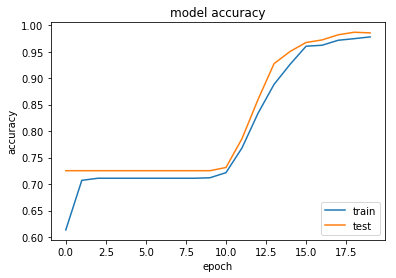

In [16]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()


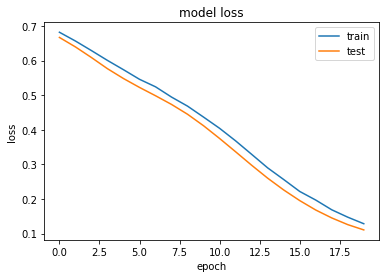

In [17]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

From this point forward we just call the ready-to-use functions for graph illustration that we presented above.

[[714  13]
 [  4 300]]


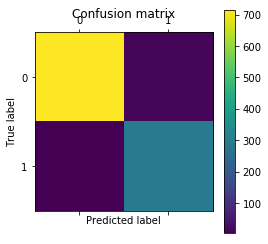

In [18]:
conf_matrix(label_test, mlp_test_predictions)

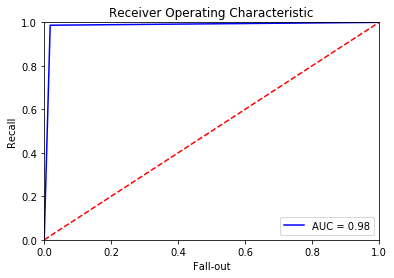

In [19]:
receiver_curv(label_test, mlp_test_predictions)

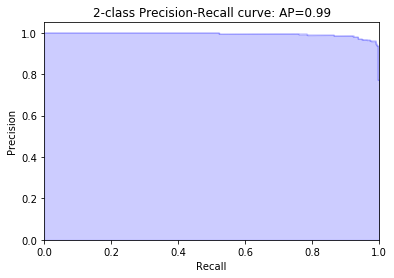

In [20]:
prec_rec_curve(mlp_model,test_x_sub,label_test)

In [73]:
mlp_results=get_results(mlp_model, train_x_sub, label_train, test_x_sub, label_test)


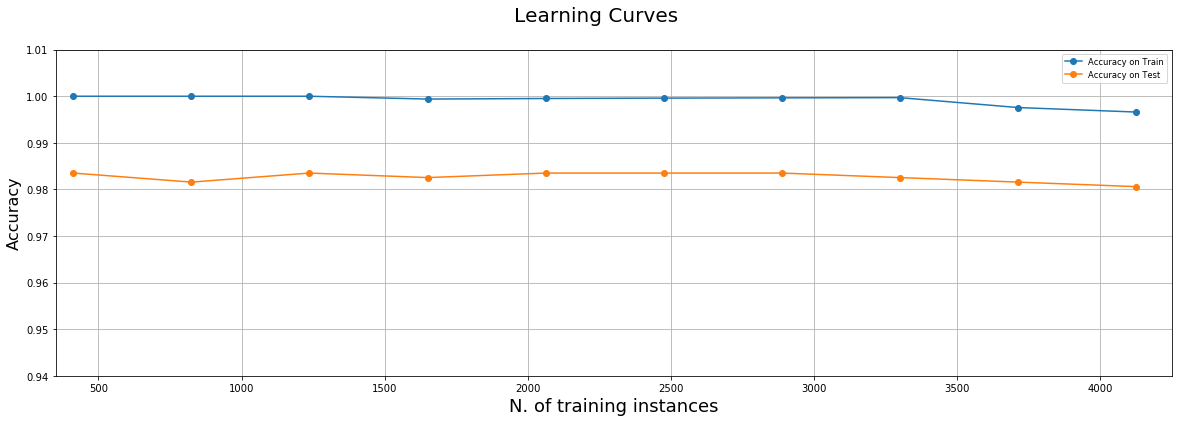

In [86]:
learning_curves(mlp_results,graph_type = 'accuracy')

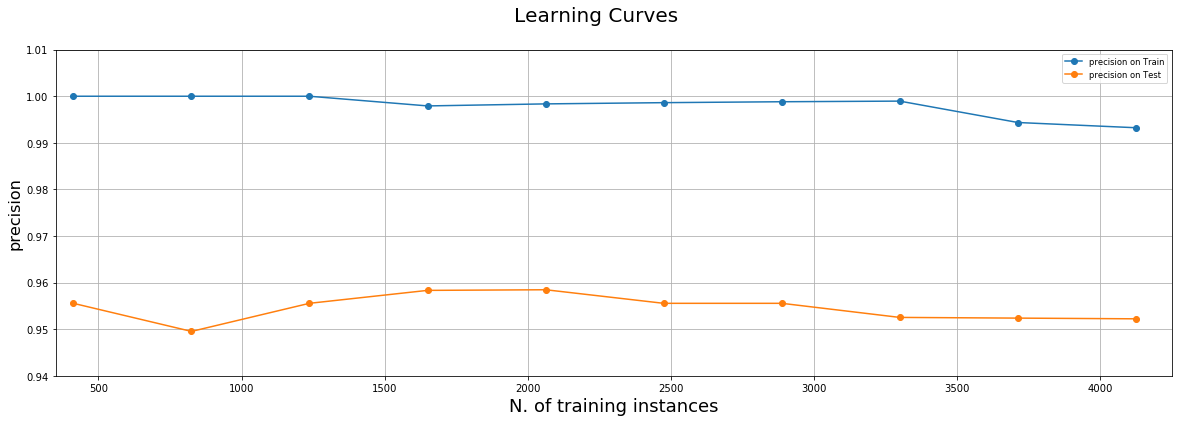

In [87]:
learning_curves(mlp_results,graph_type = 'precision')

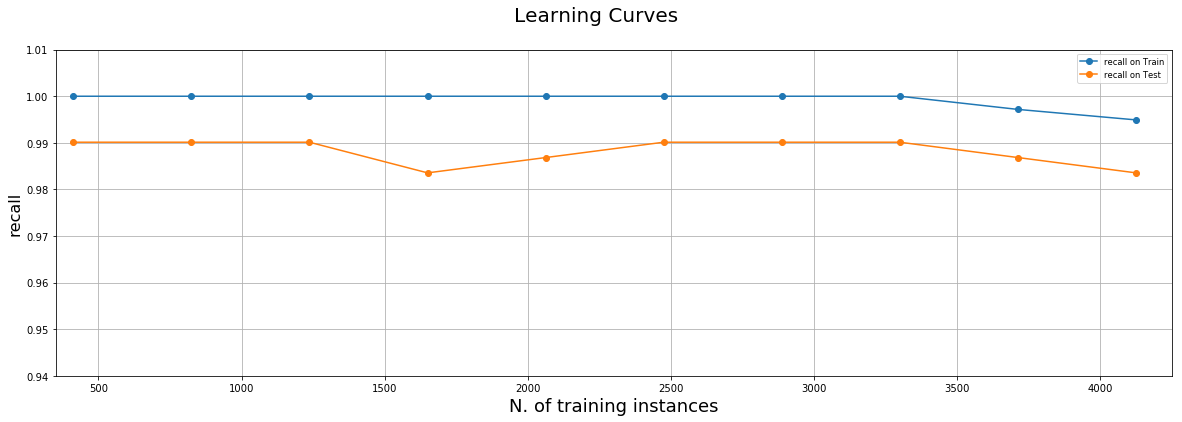

In [98]:
learning_curves(mlp_results,graph_type = 'recall')

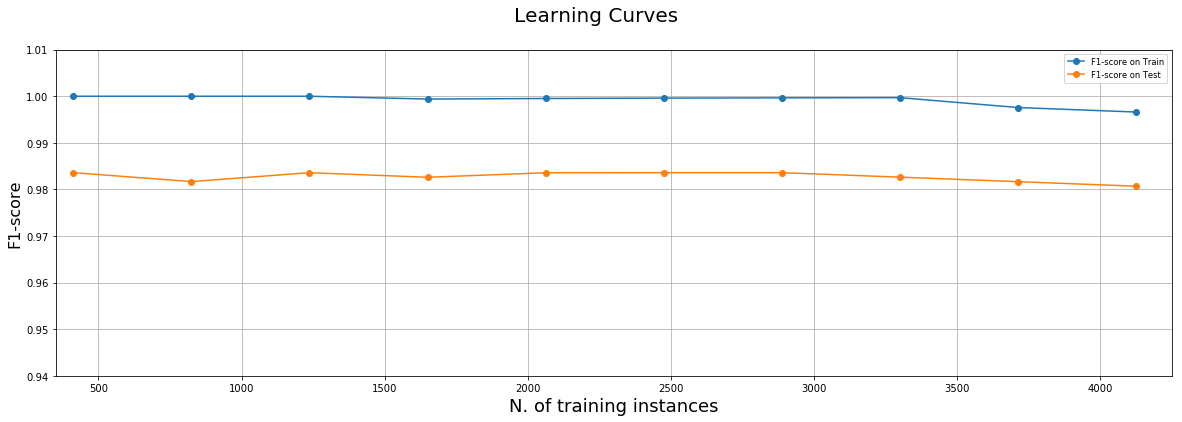

In [95]:
learning_curves(mlp_results,graph_type = 'F1-score')


# RNN

The RNN feature vectors are different than the MLP ones and, thus, the data preprocessing phase differs. First preprocessing step is to keep only the first 5000 most frequent words of the corpus in each email

In [3]:
# Concatenates and shuffles the dataset
dataset_rnn = ham + spam
np.random.seed(1)
shuffle(dataset_rnn)

texts=[item[0] for item in dataset_rnn]

#flatten the emails
max_features = 5001
total_words = []
for text in texts:
    words = word_tokenize(text)
    for word in words:
        total_words.append(word)

#create a list with the 5,000 most frequent words
words = Counter(total_words)
keep_words = words.most_common(max_features)
keep_words = [item[0] for item in keep_words]
#remove '-' because all emails are full of that symbol
keep_words.remove('-')

#create a new dataset with texts that contain only the 5,000 most frequent words
new_dataset_rnn = []
for i in range(len(texts)):
    words = word_tokenize(texts[i])
    temp_list=[]
    for word in words:
        if word in keep_words:
            temp_list.append(word)
    new_dataset_rnn.append(' '.join(temp_list))
            

train_set_rnn = new_dataset_rnn[:int(ceil(len(new_dataset_rnn)*0.8))]
test_set_rnn = new_dataset_rnn[int(ceil(len(new_dataset_rnn)*0.8)):]

# Reads class labels
label_train_rnn = [item[1] for item in dataset_rnn[:int(ceil(len(dataset_rnn)*0.8))]]
label_test_rnn = [item[1] for item in dataset_rnn[int(ceil(len(dataset_rnn)*0.8)):]]

 Then we convert our features into sequences of lenth 100

In [4]:
#set the maximum length of words of each instance
maxlen = 100

#tokenize all emails
rnn_tokenizer = Tokenizer()
rnn_tokenizer.fit_on_texts(new_dataset_rnn)
#convert emails to numeric sequences
train_seqs = rnn_tokenizer.texts_to_sequences(train_set_rnn)
test_seqs = rnn_tokenizer.texts_to_sequences(test_set_rnn)

#add padding to all emails with length smaller than 100
train_x_sub_rnn = pad_sequences(train_seqs, maxlen = maxlen)
test_x_sub_rnn = pad_sequences(test_seqs, maxlen = maxlen)

Set up the RNN model

In [6]:
def RNN():
    top_words=5000
    embedding_vecor_length = 32
    maxlen=100
    
    model = Sequential()
    model.add(Embedding(top_words,embedding_vecor_length, input_length=maxlen))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(100)))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    
    print(model.summary())
    adam = optimizers.Adam(lr=0.0001)
    model.compile(loss='binary_crossentropy',
                  optimizer=adam,
                  metrics=['accuracy'])

    return model

Fit the model to the data

In [7]:
rnn_model=RNN()
rnn_history = rnn_model.fit(
    train_x_sub_rnn,                      
    label_train_rnn,
    epochs=20,
    batch_size=64,
    verbose=0,
    validation_split=0.2
)


rnn_score_train = rnn_model.evaluate(
    train_x_sub_rnn,
    label_train_rnn,
    batch_size=64,
    verbose=0
)

rnn_score_test = rnn_model.evaluate(
    test_x_sub_rnn,
    label_test_rnn,
    batch_size=64,
    verbose=0
)

    
print('Binary_crossentropy of training data : {0:0.3f} '.format(rnn_score_train[0]))
print('Accuracy on training data : {0:0.3f} %'.format(100*rnn_score_train[1]))
print('Binary_crossentropy of test data : {0:0.3f} '.format(rnn_score_test[0]))
print('Accuracy on test data : {0:0.3f} %'.format(100*rnn_score_test[1]) )

rnn_test_predictions = rnn_model.predict_classes(np.array(test_x_sub_rnn))
rnn_precision = metrics.precision_score(label_test_rnn, rnn_test_predictions)
rnn_recall = metrics.recall_score(label_test_rnn, rnn_test_predictions)
rnn_test_f1_score =  metrics.f1_score(label_test_rnn, rnn_test_predictions)
rnn_test_accuracy = metrics.accuracy_score(label_test_rnn, rnn_test_predictions)

rnn_train_predictions = rnn_model.predict_classes(np.array(train_x_sub_rnn))
rnn_train_f1_score =  metrics.f1_score(label_train_rnn, rnn_train_predictions)
rnn_train_accuracy = metrics.accuracy_score(label_train_rnn, rnn_train_predictions)

print('Precision on test: {0:0.3f} %'.format(100*rnn_precision) )
print('Recall on test: {0:0.3f} %'.format(100*rnn_recall))
print('F1 score on test: {0:0.3f} %'.format(100*rnn_test_f1_score))



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 100, 32)           160000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 100, 32)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200)               106400    
_________________________________________________________________
dropout_2 (Dropout)          (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 201       
Total params: 266,601
Trainable params: 266,601
Non-trainable params: 0
_________________________________________________________________
None
Binary_crossentropy of training data : 0.077 
Accuracy on training data : 97.698 %
Binary_crossentropy of test data : 0.143 
Accura

Get the relevant graphs as in MLP

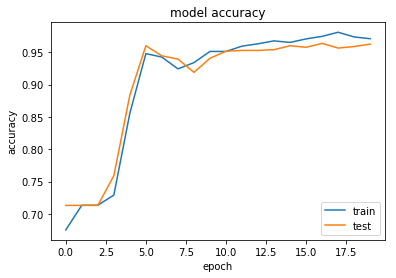

In [8]:
# summarize history for accuracy
plt.plot(rnn_history.history['acc'])
plt.plot(rnn_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

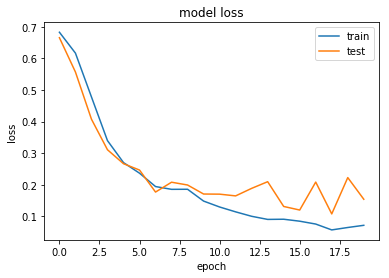

In [9]:
# summarize history for loss
plt.plot(rnn_history.history['loss'])
plt.plot(rnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

[[690  39]
 [ 10 292]]


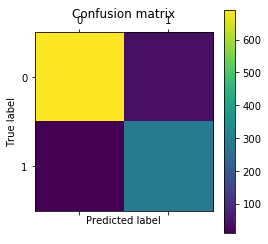

In [17]:
conf_matrix(label_test_rnn, rnn_test_predictions)

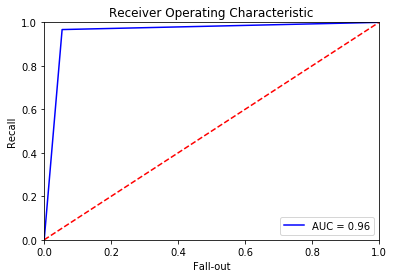

In [18]:
receiver_curv(label_test_rnn, rnn_test_predictions)

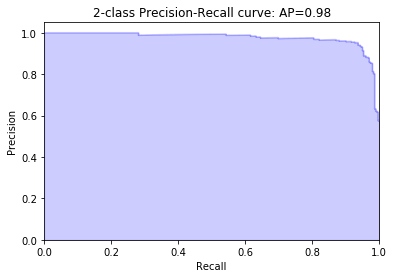

In [19]:
prec_rec_curve(rnn_model,test_x_sub_rnn,label_test_rnn)

In [20]:
rnn_results=get_results(rnn_model, train_x_sub_rnn, label_train_rnn, test_x_sub_rnn, label_test_rnn)


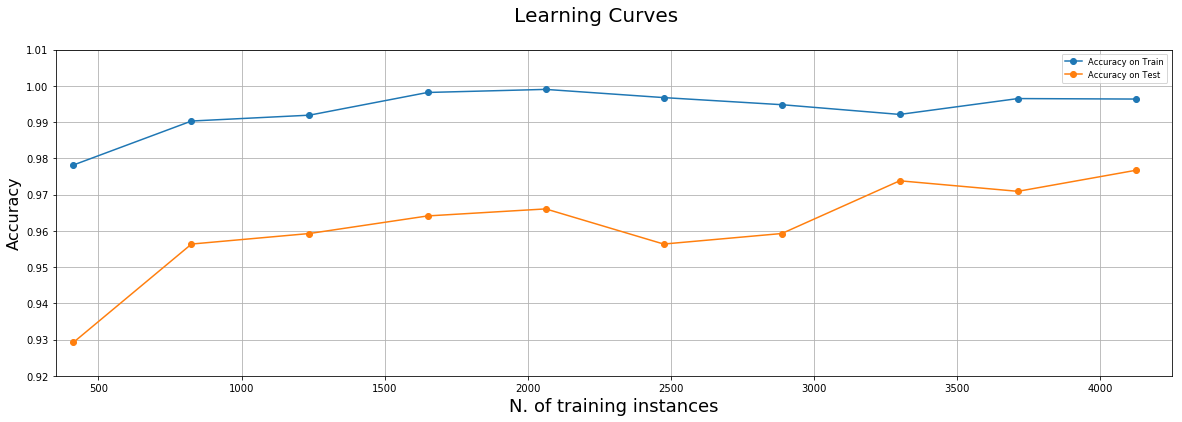

In [27]:
learning_curves(rnn_results,graph_type = 'accuracy',y_lower=0.92)

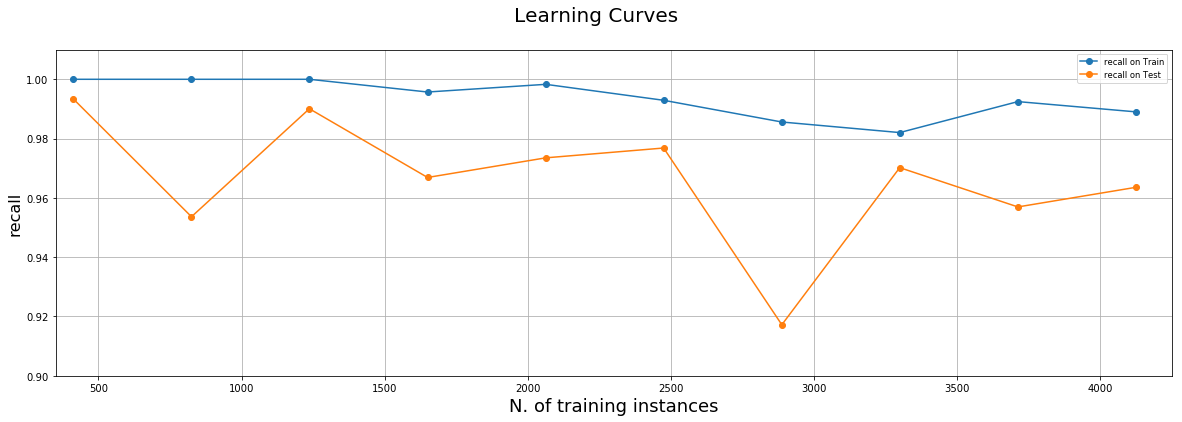

In [28]:
learning_curves(rnn_results,graph_type = 'recall',y_lower=0.9)

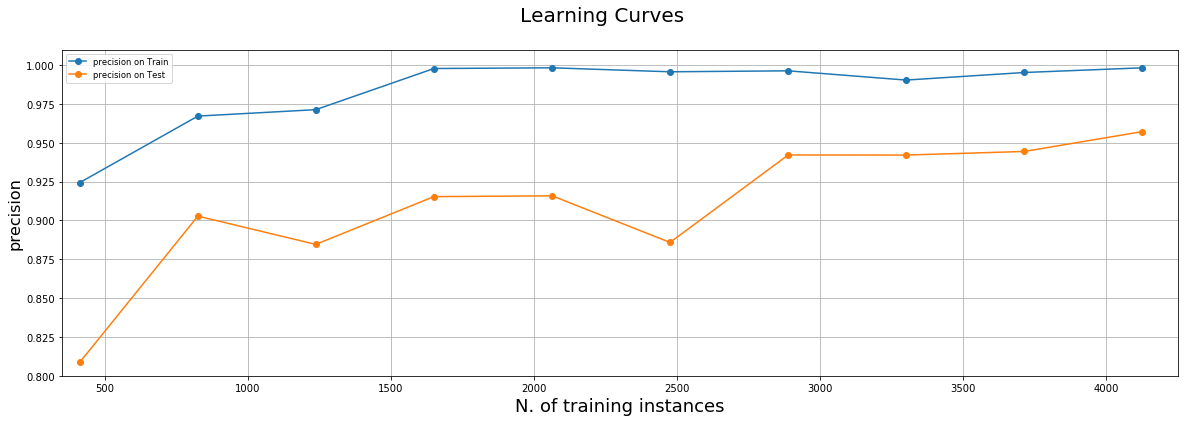

In [31]:
learning_curves(rnn_results,graph_type = 'precision',y_lower=0.8)

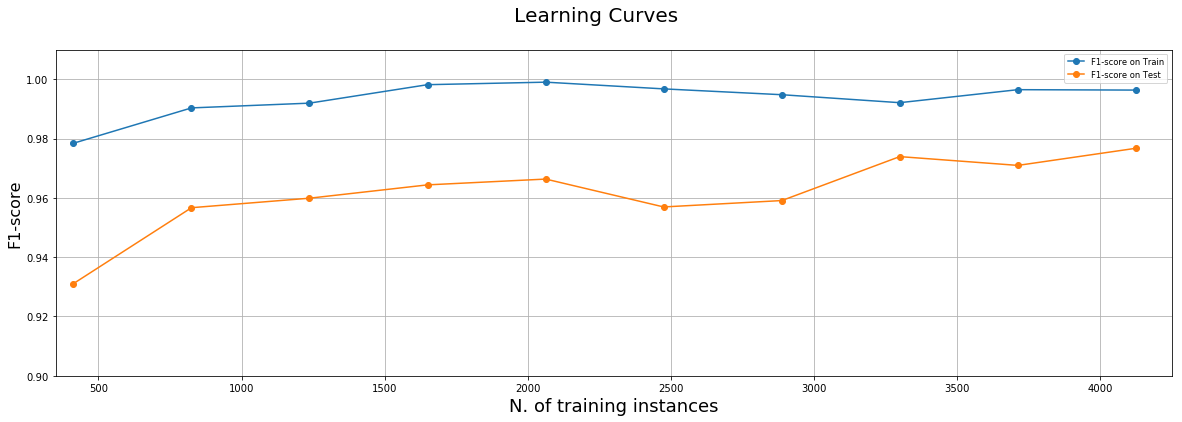

In [33]:
learning_curves(rnn_results,graph_type = 'F1-score',y_lower=0.9)